<a href="https://colab.research.google.com/github/alexbrill/tf-train/blob/main/cat_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
import os
import time
from IPython import display


In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

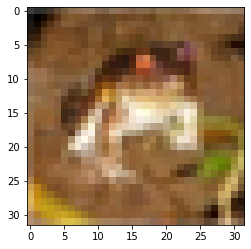

In [3]:
CAT_LABEL = 3

#cat_images = train_images[np.where(train_labels == CAT_LABEL)[0]]
cat_images = train_images
plt.imshow(cat_images[0])

In [4]:
cat_images.shape

(50000, 32, 32, 3)

In [5]:
#cat_images = cat_images.reshape(cat_images.shape[0], 28, 28, 3).astype('float32')
cat_images = (cat_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(cat_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
def build_generator():
  model = keras.models.Sequential()

  model.add(keras.layers.Dense(256*4*4, input_dim=100, use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())

  model.add(keras.layers.Reshape((4, 4, 256)))

  model.add(keras.layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())

  model.add(keras.layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())

  model.add(keras.layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())

  model.add(keras.layers.Conv2DTranspose(3, (5,5), use_bias=False, activation='tanh', padding='same'))

  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

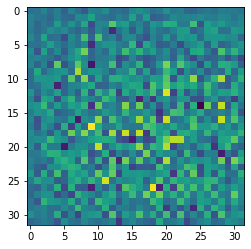

In [9]:
generator = build_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])
generator.summary()

In [10]:
def build_discriminator():
  model = keras.models.Sequential()

  model.add(keras.layers.Conv2D(64, (5,5), padding='same', input_shape=(32,32,3)))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(keras.layers.Dropout(0.3))

  model.add(keras.layers.Conv2D(128, (5,5), strides=(2, 2), padding='same'))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(keras.layers.Dropout(0.3))

  model.add(keras.layers.Conv2D(128, (5,5), strides=(2, 2), padding='same'))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(keras.layers.Dropout(0.3))

  model.add(keras.layers.Conv2D(256, (5,5), strides=(2, 2), padding='same'))
  model.add(keras.layers.LeakyReLU(alpha=0.2))
  model.add(keras.layers.Dropout(0.3))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1))

  return model

In [11]:
discriminator = build_discriminator()
decision = discriminator(generated_image)

print(decision)
discriminator.summary()

tf.Tensor([[-0.00070406]], shape=(1, 1), dtype=float32)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
________________________________________________________________

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [19]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


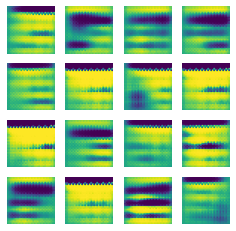

Time for epoch 5 is 51.23597192764282 sec


In [ ]:
train(train_dataset, 40)
